# Ocular Disease Recognition - Model Training

## 1. Overview & Preprocessing

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import cv2

import torch
torch.__version__

'2.5.0+cu118'

### 1.1 Exploratory data analysis

An issue with the data is that the diagnosis encodings in the one-hot-encoded columns (columns labeled C, D, G...), in particular the numeric encoded diagnosis are incorrect. However the `target` field is correct for the eye referenced in `filename` and matched the diagnostic keywords for the respective eye.

In [2]:
df = pd.read_csv('./input/ocular-disease-recognition-odir5k/full_df.csv')

df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


### 1.2 Problems with the encoded categories

We found that relying on the encoded diagnosis categories "N D G C A H M O" could be problematic in the sense that sthey are incorrect. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information.

Therefore we will exclude those categories for this notebook although they could certainly be used for other investigations.

In [3]:
raw_data = df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'labels'])

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


The number of classes will correspond to the number of unique lables in the `labels` column, this data set contains 8 classes corresponding the the diagnosis in the list above

In [4]:
raw_data["target"].unique().size

8

In [5]:
raw_data.shape

(6392, 10)

### 1.3 绘制每个类别的样本数量

In [6]:
targets = np.array(raw_data["target"].apply(lambda x: json.loads(x)).tolist())


targets.shape

(6392, 8)

In [7]:
classes = { 0: "Normal",
            1: "Diabetes",
            2: "Glaucoma",
            3: "Cataract",
            4: "Age related Macular Degeneration",
            5: "Hypertension",
            6: "Pathological Myopia",
            7: "Other diseases/abnormalities"
          }

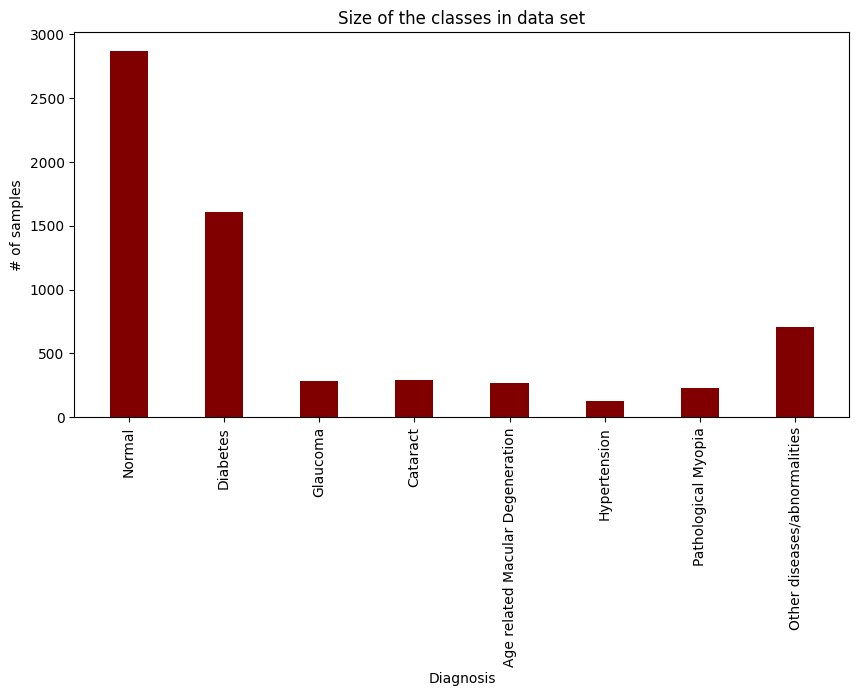

In [8]:
# 创建数据集
data = np.sum(targets, axis=0)

classes_names = list(classes.values())
values = list(data)
  
fig = plt.figure(figsize = (10, 5))
 
# 创建条形图
plt.bar(classes_names, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Diagnosis")
plt.ylabel("# of samples")
plt.title("Size of the classes in data set")

plt.xticks(rotation=90)

plt.show()

在此注意数据集是不平衡的，但是每个类别有超过 100 个样本图像，因此每个类别应该有足够的数据来训练分类问题。

### 1.4 各类别的绘图示例

In [9]:
img_dir = "./input/ocular-disease-recognition-odir5k/preprocessed_images"

In [10]:
raw_data["class_name"] = np.argmax(targets, axis=1).tolist()
raw_data["class_name"] = raw_data["class_name"] .replace(classes)

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


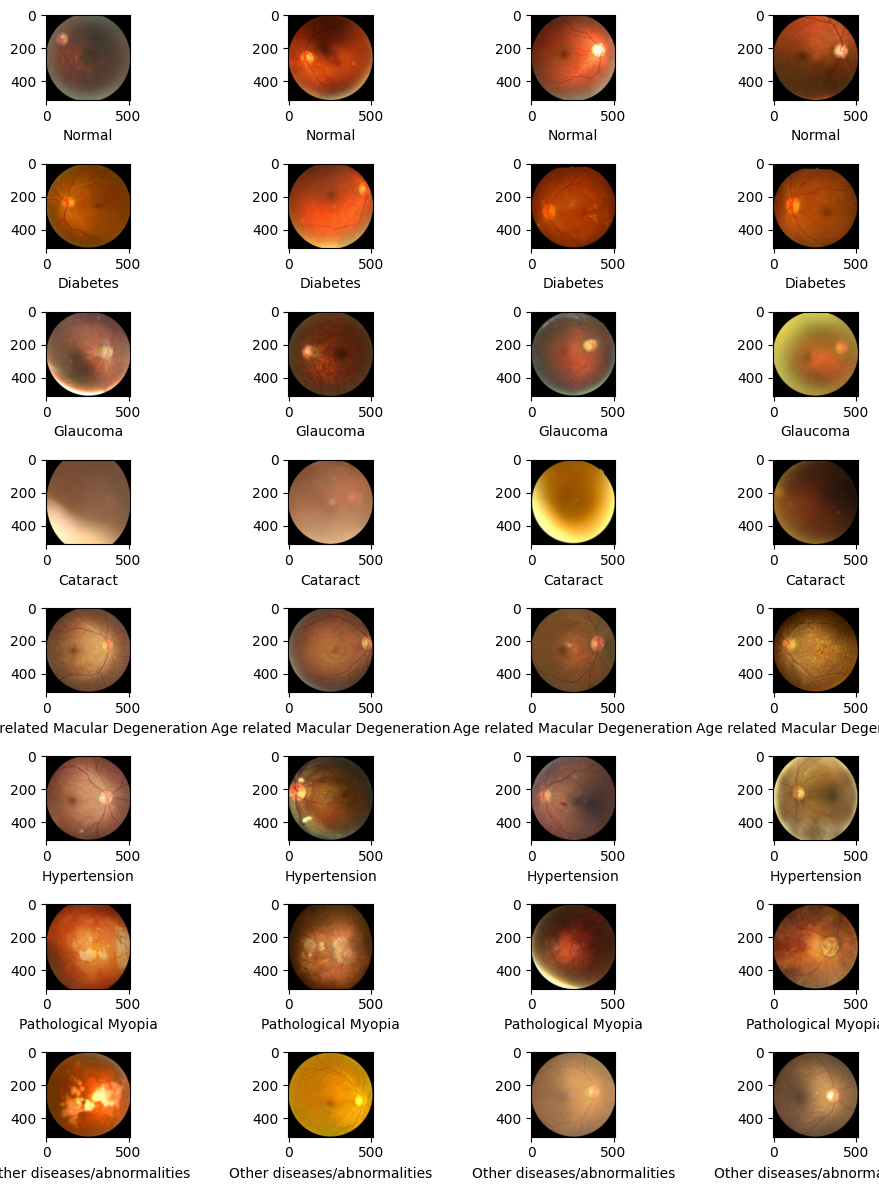

In [11]:
plt.figure(figsize=(12, 12))

for i, class_name in enumerate(classes.values()):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## 转换图像为RGB格式
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## 子图变量subplot variables - （行数、列数、遍历网格上的位置）(# of rows, # of columns, iterate through locations on grid)
        plt.subplot(8, 4, 4 * i + j + 1)
        plt.imshow(image_rgb, aspect=1)
        
        ## 有文件名和诊断的标签
        plt.xlabel('{}'.format(class_name))

        plt.tight_layout() 

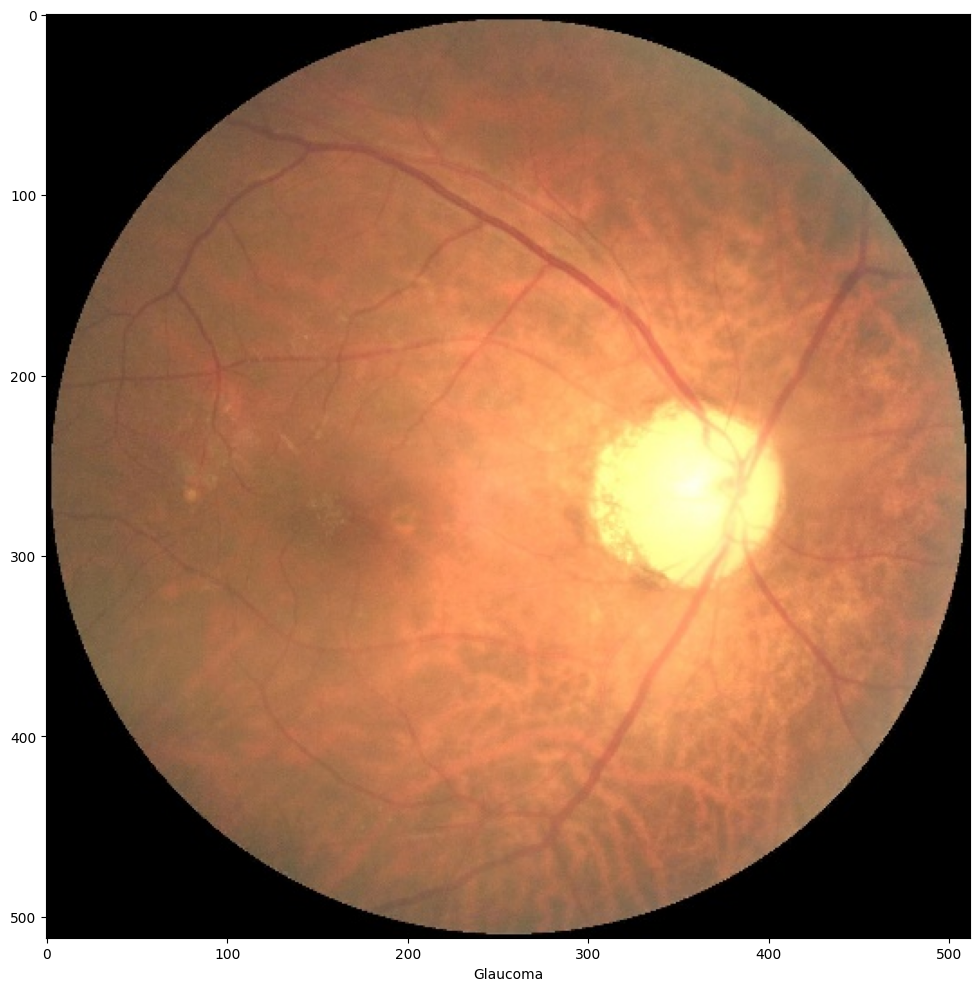

In [12]:
plt.figure(figsize=(12, 12))

single_class = ["Glaucoma"] #青光眼

for i, class_name in enumerate(single_class):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## 转为rgb格式
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## 子图变量subplot variables - （行数、列数、遍历网格上的位置）(# of rows, # of columns, iterate through locations on grid)
        # plt.subplot(8, 4, 4 * i + j + 1)同上
        plt.imshow(image_rgb, aspect=1)
        
        ## 有文件名和诊断的标签
        plt.xlabel('{}'.format(class_name))

### 1.5 保存清洗好后的标签

In [13]:
processed_labels = raw_data[["ID", "filename", "class_name", "target"]]
processed_labels.to_csv('./working/labels_clean.csv', index=False)

processed_labels.head()

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2,2_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4,4_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5,5_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"


## 2. Import Libraries

In [14]:
# 导入库
import json
import os
import pickle
import random
import time

# 忽略警告
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform
# from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
# from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch 数据集
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid

warnings.filterwarnings("ignore")

plt.ion()  # 交互模式

from __future__ import print_function, division

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
# 检查CUDA
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [16]:
!nvidia-smi

Fri Mar 28 21:24:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0             25W /  140W |     448MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2.1 定义辅助函数

In [17]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # 为输入和目标创建变量
    inputs = Variable(images)
    targets = Variable(images)

    # 清除所有变量的梯度避免干扰
    optimizer.zero_grad()

    # 前向传递，然后后向传递，然后更新权重
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True
#用于快速验证神经网络是否能完成一次完整的前向传播、反向传播和参数更新。避免因梯度爆炸/消失或数据加载错误导致训练失败

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
#将标准化后的张量图像反归一化并可视化。显示原始图像与增强后的对比，可检查数据增强（如随机裁剪、翻转）后图像是否失真

def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')
#并排对比原始图像与模型重建图像
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    #可视化图像及其预测概率分布

# 训练前：用 imshow 检查数据加载和增强效果，确保病变区域不被遮挡或扭曲。
# 训练中：用 test_network 验证单步训练稳定性，view_recon 监控自编码器重建质量。
# 训练后：用 view_classify 分析模型在测试集上的预测结果，识别易混淆疾病类

In [18]:
def show_images(image):
    """Show image"""
    plt.imshow(image)
    plt.pause(0.001)  # 暂停一下，以便更新图像

## 3. 定义 `OcularDiseaseRecognition` 类

In [19]:
class OcularDiseaseRecognition(Dataset):
    """Ocular Disease Recognition."""
#通过 CSV 文件（csv_file）读取患者 ID、图像路径和标签信息，并关联存储图像的根目录（root_dir）。
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 1])
        image = io.imread(img_name)
        target = self.labels_frame.iloc[idx, 3]
        target = np.array(json.loads(target))
        sample = {'image': image, 'labels': target}

        if self.transform:
            sample = self.transform(sample)

        return sample
    #ODIR-5K 中一个患者可能同时患有多种疾病（如糖尿病视网膜病变+高血压），通过 json.loads 解析标签字符串为数组，适配多标签分类任务的损失函数（如 BCEWithLogitsLoss）。
class Rescale(object):
    """将样本中的图像重新缩放为给定大小。

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    参数：
        output_size（元组或整数）：所需的输出大小。如果是元组，则输出与 output_size 匹配。如果是整数，则将较小的图像边缘与 output_size 匹配，同时保持纵横比不变。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'labels': label}
#将图像按比例缩放到指定尺寸（如 512x512），保持纵横比以防止形变。

class RandomCrop(object):
    """随机裁剪样本中的图像。

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    参数：output_size（元组或整数）：所需的输出大小。如果是整数，则进行方形裁剪。
        
    """
#随机裁剪样本图像至固定尺寸（如 448x448）。增加模型对病灶位置变化的鲁棒性.小样本下需通过裁剪提升数据多样性。
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'labels': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
#将图像从 H×W×C（NumPy 格式）转为 C×H×W（PyTorch 张量），并保留标签为张量。适配 PyTorch 模型输入。多标签支持，标签转为张量后可直接用于多标签损失计算。
    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        # 交换颜色轴因为
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(label)}

## 4. 定义 Pytorch `Dataloader` & 加载数据

### 4.1 Load Labels

In [20]:
!pwd

'pwd' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [21]:
labels = pd.read_csv('./working/labels_clean.csv')

n = 65
img_name = labels.iloc[n, 1]
class_name =  labels.iloc[n, 2]
target = labels.iloc[n, 3]

print('Image name: {}'.format(img_name))
print('Class Name: {}'.format(class_name))
print('Target: {}'.format(target))

Image name: 81_right.jpg
Class Name: Diabetes
Target: [0, 1, 0, 0, 0, 0, 0, 0]


In [22]:
labels.head(2)

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"


In [23]:
labels.shape

(6392, 4)

### 4.2 Load Image Data

In [24]:
# # 用于数据加载的子进程数
num_workers = 0
# 每批次要加载多少个样本
batch_size = 32
# 用于验证的训练集百分比
valid_size = 0.2
test_size = 0.2

In [25]:
# 选择训练和测试数据集
img_dir = "./input/ocular-disease-recognition-odir5k/preprocessed_images"
labels_dir = './working/labels_clean.csv'

full_data  = OcularDiseaseRecognition(csv_file=labels_dir, 
                                      root_dir=img_dir, 
                                      transform=transforms.Compose([Rescale(512),
                                                                    ToTensor()])
                                     )

In [26]:
# 获取用于验证的训练指标
num_train = len(full_data)
indices = list(range(num_train))

np.random.shuffle(indices)

val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(valid_size * num_train))


test_idx, valid_idx, train_idx = indices[:test_split], indices[test_split: test_split + val_split], indices[test_split + val_split:]

In [27]:
num_train

6392

In [28]:
# 定义用于获取训练和验证批次的采样器
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

In [29]:
# 准备数据加载器（结合数据集和采样器）
train_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [30]:
len(train_loader)

120

### 4.3 可视化一批训练数据

In [31]:
# 辅助函数来取消规范化并显示图像
def imshow(img):
    img = img / 2 + 0.5  # 反规范化
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 从 Tensor 图像转换

In [32]:
# 获取一批训练图像
dataiter = iter(train_loader)
sample = next(dataiter)

sample['image'].shape # (number of examples: 20, number of channels: 3, pixel sizes: 256x256)示例数量：20，通道数量：3，像素大小：256x256

torch.Size([32, 3, 512, 512])

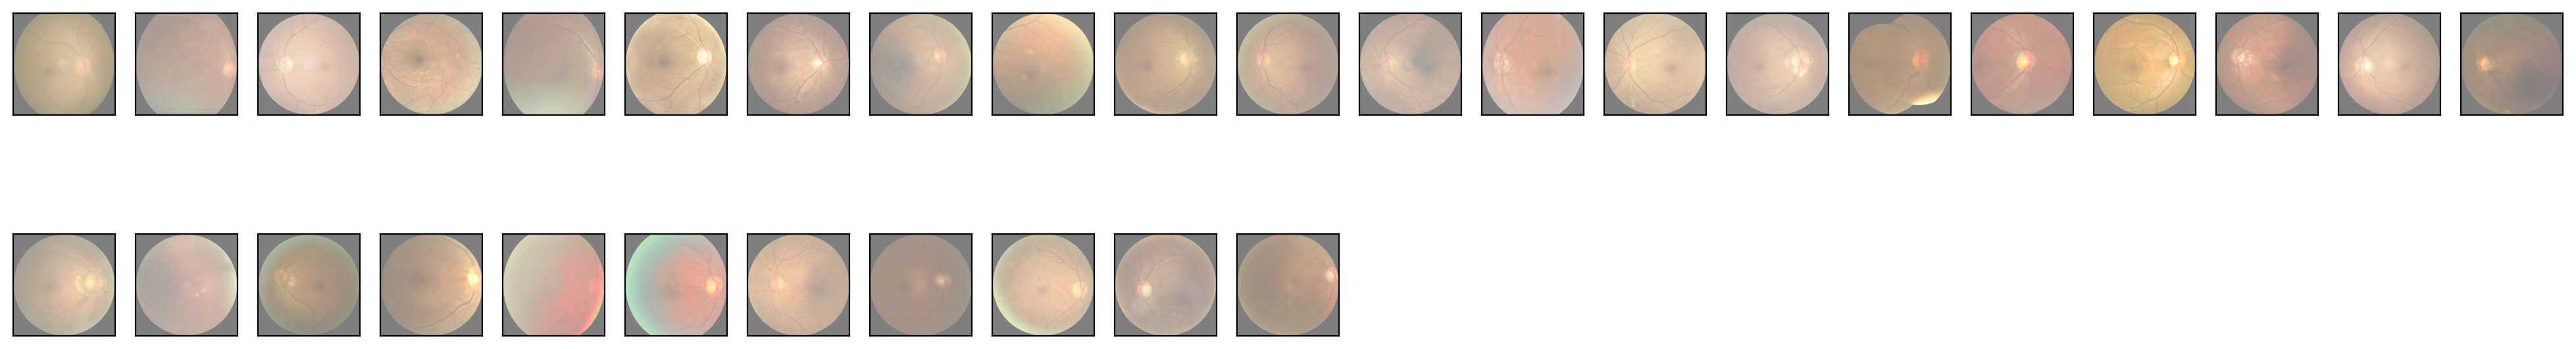

In [33]:
# 绘制批次中的图像以及相应的标签
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 21, idx+1, xticks=[], yticks=[])
    imshow(sample['image'][idx])

## 5. 模型训练

In [34]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [35]:
def save_checkpoint(state, is_best, filename='./working/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

### 5.1 定义模型架构

In [36]:
import torch
import torch.nn as nn
from torchvision import models

# 配置设备（适配Kaggle GPU环境）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 正确初始化模型（消除警告的关键）[1,4](@ref)
resnet_model = models.resnet50(weights=None)  # 使用新API阻止自动下载

# 加载本地预训练权重（Kaggle输入数据集路径）[2,6](@ref)
local_weights_path = './input/resnet_50/resnet50-0676ba61.pth'
try:
    state_dict = torch.load(local_weights_path, map_location=device)  # 设备映射
    resnet_model.load_state_dict(state_dict)
    print("本地权重加载成功")
except Exception as e:
    print(f"权重加载失败：{str(e)}")
    raise

# 冻结早期层
for param in list(resnet_model.parameters())[:-20]:
    param.requires_grad = False

# 获取fc全连接层层的输入
n_inputs = resnet_model.fc.in_features

# 重新定义 fc 层/顶层/头以解决我们的分类问题
num_classes = 8
resnet_model.fc = nn.Sequential(
    # nn.Linear(n_inputs, 2048),
    # nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(n_inputs, 512),#减少全连接层神经元数量，降低模型复杂度
    nn.ReLU(),
    nn.BatchNorm1d(512), #添加批量归一化
    nn.Dropout(p=0.3),
    nn.Linear(512, num_classes)
    )

# 将模型的所有参数设置为可训练
# for name, child in resnet_model.named_children():
#     for name2, params in child.named_parameters():
#         params.requires_grad = True


# 将模型分发到所有 GPU
resnet_model = nn.DataParallel(resnet_model)

# 根据可用性将模型设置为在 GPU 或 CPU 上运行
resnet_model.to(device)

# 打印迁移学习 CNN 模型架构
resnet_model

本地权重加载成功


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [37]:
# Limit maximum memory usage to 1GB

# torch.backends.cuda.reserved_memory = 4 * 1024 * 1024 * 1024
# torch.backends.cuda.max_allocated_memory = 4 * 1024 * 1024 * 1024
# 将最大内存使用量限制为 1GB

# torch.backends.cuda.reserved_memory = 4 * 1024 * 1024 * 1024
# torch.backends.cuda.max_allocated_memory = 4 * 1024 * 1024 * 1024

### 5.2 Define `Criterion` & `Optimizer`定义“标准”和“优化器”

In [38]:
# 损失函数
# 如果 GPU 可用，则设置损失函数以使用 GPU
criterion = nn.CrossEntropyLoss().to(device)

# 优化器
# optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4, weight_decay=1e-5)



# 用于存储损失和准确度的空列表
train_losses = []
test_losses = []
train_correct = []
test_correct = []

### 5.3 运行训练循环

In [39]:
# 训练迭代次数
epochs = 32

In [40]:
torch.cuda.empty_cache()

In [41]:
# 设置训练开始时间
start_time = time.time()

# 将检查点阈值 best_prec 损失值设置为 2
best_prec1 = 2
is_best = False

# 空批次变量
b = None
train_b = None
test_b = None

scaler = GradScaler()

for i in range(epochs):
    # 每次迭代时清空训练正确计数器并测试正确计数器为 0
    trn_corr = 0
    tst_corr = 0
    trn_loss = 0
    tst_loss = 0
    
    # 设置循环的开始时间
    e_start = time.time()
    

    # 分批训练
    from tqdm import tqdm
    for b, sample in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch: {i}"):
        # 如果设备是 cuda，则将标签设置为 cuda
        X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)
        
        # 前向传递图像样本
        y_pred = resnet_model(X.view(-1, 3, 512, 512))

        # 计算损失
        loss = criterion(y_pred.float(), y.float())

        trn_loss += loss.item()
        # 获取预测张量的 argmax，也就是我们的标签
        predicted = torch.argmax(y_pred, dim=1).data
        y = torch.argmax(y, dim=1).data

        # 如果预测标签与真实标签正确，则计算样本总和

        batch_corr = (predicted == y).sum()
        # 每批增量训练正确，并正确预测标签
        trn_corr += batch_corr.item()
        
        # 将优化器梯度设置为零
        optimizer.zero_grad()
        # 通过自动广播进行反向传播
        # 带损失反向传播
        scaler.scale(loss).backward()
        # 执行优化器步骤
        scaler.step(optimizer)
        scaler.update()
      
    # 设置循环的结束时间
    e_end = time.time()
    
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)}\nAccuracy: {trn_corr*100/(b*batch_size):2.2f} %  Loss: {trn_loss/len(train_loader):2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') 
    
    # 一些用于可视化的指标存储
    train_b = b
    train_losses.append(trn_loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # 使用验证生成器进行验证
    # 验证时不执行任何梯度更新 
    with torch.no_grad():
        for b, sample in enumerate(valid_loader):
            # 如果设备是 cuda，则将标签设置为 cuda
            X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)

            # 前向传递图像
            y_val = resnet_model(X.view(-1, 3, 512, 512))

            # 获取预测张量的 argmax，也就是我们的标签
            predicted = torch.argmax(y_val, dim=1).data
            y = torch.argmax(y, dim=1).data

            # 每批增量测试正确，并正确预测标签
            tst_corr += (predicted == y).sum().item()

            # 获得验证集损失
            loss = criterion(y_val.float(), y.long())
            tst_loss += loss.item()
            
            
    # 打印验证指标
    print(f'Validation Accuracy {tst_corr*100/(b*batch_size):2.2f}% Validation Loss: {tst_loss/len(valid_loader):2.4f}\n')

    # 如果当前验证损失小于前几次迭代验证损失，则创建并保存检查点
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    
    if is_best:
        save_checkpoint({
                'epoch': i + 1,
                'state_dict': resnet_model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)
        
        is_best = False

    # 一些用于可视化的指标存储
    test_b  = b
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)

# 设置总训练的结束时间
end_time = time.time() - start_time    

# 打印培训摘要
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch: 0: 100%|██████████| 120/120 [03:17<00:00,  1.65s/it]


Epoch 1 Batch 120
Accuracy: 38.92 %  Loss: 1.8203  Duration: 3.30 minutes
Validation Accuracy 53.69% Validation Loss: 1.5246



Epoch: 1: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 2 Batch 120
Accuracy: 55.99 %  Loss: 1.4238  Duration: 3.17 minutes
Validation Accuracy 58.33% Validation Loss: 1.3846



Epoch: 2: 100%|██████████| 120/120 [03:13<00:00,  1.62s/it]


Epoch 3 Batch 120
Accuracy: 64.23 %  Loss: 1.1448  Duration: 3.23 minutes
Validation Accuracy 59.29% Validation Loss: 1.3285



Epoch: 3: 100%|██████████| 120/120 [03:09<00:00,  1.58s/it]


Epoch 4 Batch 120
Accuracy: 71.77 %  Loss: 0.9082  Duration: 3.16 minutes
Validation Accuracy 58.81% Validation Loss: 1.3613



Epoch: 4: 100%|██████████| 120/120 [03:13<00:00,  1.61s/it]


Epoch 5 Batch 120
Accuracy: 78.39 %  Loss: 0.6856  Duration: 3.23 minutes
Validation Accuracy 58.89% Validation Loss: 1.5901



Epoch: 5: 100%|██████████| 120/120 [03:11<00:00,  1.60s/it]


Epoch 6 Batch 120
Accuracy: 85.58 %  Loss: 0.4901  Duration: 3.19 minutes
Validation Accuracy 58.01% Validation Loss: 1.6590



Epoch: 6: 100%|██████████| 120/120 [03:18<00:00,  1.66s/it]


Epoch 7 Batch 120
Accuracy: 91.75 %  Loss: 0.3008  Duration: 3.31 minutes
Validation Accuracy 56.97% Validation Loss: 1.8787



Epoch: 7: 100%|██████████| 120/120 [03:18<00:00,  1.65s/it]


Epoch 8 Batch 120
Accuracy: 94.49 %  Loss: 0.2110  Duration: 3.30 minutes
Validation Accuracy 59.21% Validation Loss: 1.9693



Epoch: 8: 100%|██████████| 120/120 [03:14<00:00,  1.62s/it]


Epoch 9 Batch 120
Accuracy: 95.54 %  Loss: 0.1701  Duration: 3.25 minutes
Validation Accuracy 58.65% Validation Loss: 1.9783



Epoch: 9: 100%|██████████| 120/120 [03:14<00:00,  1.62s/it]


Epoch 10 Batch 120
Accuracy: 97.79 %  Loss: 0.1155  Duration: 3.24 minutes
Validation Accuracy 60.42% Validation Loss: 1.9105



Epoch: 10: 100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


Epoch 11 Batch 120
Accuracy: 98.45 %  Loss: 0.0851  Duration: 3.27 minutes
Validation Accuracy 58.41% Validation Loss: 2.1464



Epoch: 11: 100%|██████████| 120/120 [03:21<00:00,  1.68s/it]


Epoch 12 Batch 120
Accuracy: 97.69 %  Loss: 0.1042  Duration: 3.35 minutes
Validation Accuracy 60.58% Validation Loss: 1.9903



Epoch: 12: 100%|██████████| 120/120 [03:18<00:00,  1.65s/it]


Epoch 13 Batch 120
Accuracy: 98.79 %  Loss: 0.0702  Duration: 3.31 minutes
Validation Accuracy 60.26% Validation Loss: 2.1069



Epoch: 13: 100%|██████████| 120/120 [04:01<00:00,  2.01s/it]


Epoch 14 Batch 120
Accuracy: 99.50 %  Loss: 0.0478  Duration: 4.02 minutes
Validation Accuracy 59.62% Validation Loss: 2.2386



Epoch: 14: 100%|██████████| 120/120 [03:21<00:00,  1.68s/it]


Epoch 15 Batch 120
Accuracy: 99.11 %  Loss: 0.0546  Duration: 3.35 minutes
Validation Accuracy 59.38% Validation Loss: 2.2671



Epoch: 15: 100%|██████████| 120/120 [03:17<00:00,  1.64s/it]


Epoch 16 Batch 120
Accuracy: 97.85 %  Loss: 0.0967  Duration: 3.28 minutes
Validation Accuracy 60.34% Validation Loss: 2.0882



Epoch: 16: 100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


Epoch 17 Batch 120
Accuracy: 99.76 %  Loss: 0.0449  Duration: 3.28 minutes
Validation Accuracy 59.13% Validation Loss: 2.4076



Epoch: 17: 100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


Epoch 18 Batch 120
Accuracy: 98.82 %  Loss: 0.0668  Duration: 3.28 minutes
Validation Accuracy 60.50% Validation Loss: 2.1982



Epoch: 18: 100%|██████████| 120/120 [03:13<00:00,  1.61s/it]


Epoch 19 Batch 120
Accuracy: 97.85 %  Loss: 0.0940  Duration: 3.23 minutes
Validation Accuracy 56.73% Validation Loss: 2.3651



Epoch: 19: 100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


Epoch 20 Batch 120
Accuracy: 98.29 %  Loss: 0.0766  Duration: 3.28 minutes
Validation Accuracy 60.66% Validation Loss: 2.2734



Epoch: 20: 100%|██████████| 120/120 [03:24<00:00,  1.71s/it]


Epoch 21 Batch 120
Accuracy: 99.87 %  Loss: 0.0338  Duration: 3.41 minutes
Validation Accuracy 61.30% Validation Loss: 2.3188



Epoch: 21: 100%|██████████| 120/120 [03:13<00:00,  1.61s/it]


Epoch 22 Batch 120
Accuracy: 99.61 %  Loss: 0.0392  Duration: 3.23 minutes
Validation Accuracy 60.42% Validation Loss: 2.3961



Epoch: 22: 100%|██████████| 120/120 [03:14<00:00,  1.62s/it]


Epoch 23 Batch 120
Accuracy: 99.84 %  Loss: 0.0351  Duration: 3.25 minutes
Validation Accuracy 61.30% Validation Loss: 2.5041



Epoch: 23: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 24 Batch 120
Accuracy: 100.21 %  Loss: 0.0241  Duration: 3.17 minutes
Validation Accuracy 62.34% Validation Loss: 2.5009



Epoch: 24: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 25 Batch 120
Accuracy: 99.47 %  Loss: 0.0394  Duration: 3.18 minutes
Validation Accuracy 60.50% Validation Loss: 2.4278



Epoch: 25: 100%|██████████| 120/120 [03:13<00:00,  1.62s/it]


Epoch 26 Batch 120
Accuracy: 98.71 %  Loss: 0.0617  Duration: 3.23 minutes
Validation Accuracy 60.82% Validation Loss: 2.4258



Epoch: 26: 100%|██████████| 120/120 [03:11<00:00,  1.59s/it]


Epoch 27 Batch 120
Accuracy: 98.53 %  Loss: 0.0699  Duration: 3.19 minutes
Validation Accuracy 59.29% Validation Loss: 2.5429



Epoch: 27: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 28 Batch 120
Accuracy: 98.84 %  Loss: 0.0632  Duration: 3.17 minutes
Validation Accuracy 60.26% Validation Loss: 2.3801



Epoch: 28: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 29 Batch 120
Accuracy: 99.97 %  Loss: 0.0298  Duration: 3.17 minutes
Validation Accuracy 62.26% Validation Loss: 2.3053



Epoch: 29: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 30 Batch 120
Accuracy: 100.08 %  Loss: 0.0258  Duration: 3.18 minutes
Validation Accuracy 61.54% Validation Loss: 2.5454



Epoch: 30: 100%|██████████| 120/120 [03:10<00:00,  1.59s/it]


Epoch 31 Batch 120
Accuracy: 99.53 %  Loss: 0.0376  Duration: 3.18 minutes
Validation Accuracy 56.65% Validation Loss: 2.9006



Epoch: 31: 100%|██████████| 120/120 [03:12<00:00,  1.60s/it]


Epoch 32 Batch 120
Accuracy: 99.24 %  Loss: 0.0473  Duration: 3.20 minutes
Validation Accuracy 63.14% Validation Loss: 2.3702


Training Duration 139.06 minutes
GPU memory used : 436052992 kb
GPU memory cached : 3013607424 kb


In [42]:
print(f'Validation accuracy: {test_correct[-1]*100/(test_b*batch_size):.2f}%')

Validation accuracy: 63.14%


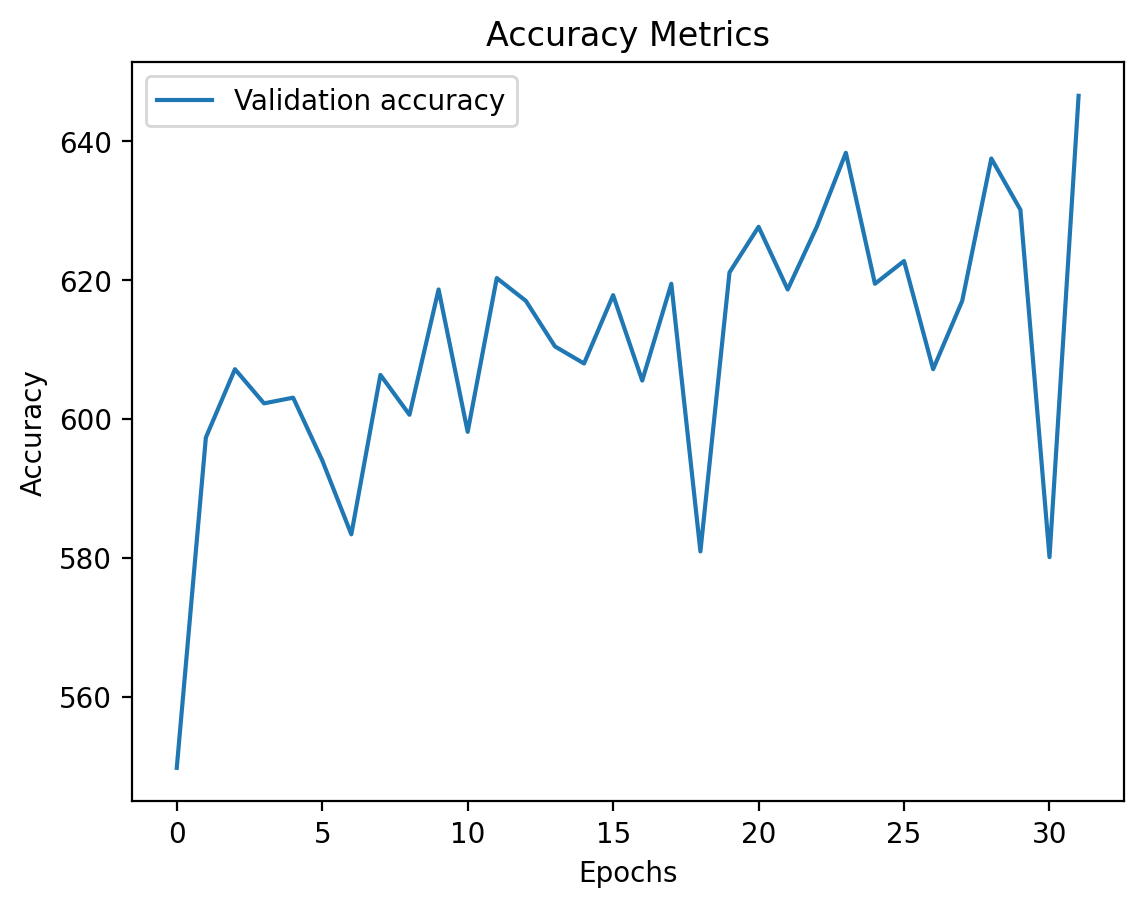

In [43]:
plt.plot([t/test_b*batch_size for t in torch.tensor(test_correct).cpu()], label='Validation accuracy')

plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend()
plt.show()